In [1]:
import pandas as pd
import numpy as np
import deductive_system
import treatmentKG
# import treatmentKG_experiment

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.colors as mcolors

In [2]:

input_path = 'Input/'

#negative_treatment = input_path + 'treatment_negative_effect.csv'
#positive_treatment = input_path + 'treatment_positive_effect.csv'

negative_treatment = 'dataset/Patient_negative.csv'
positive_treatment = 'dataset/Patient_positive.csv'

d_no_onco = input_path + 'patient_nonOncologycalTreatments.csv'

negative_treatment = pd.read_csv(negative_treatment, delimiter=",")
positive_treatment = pd.read_csv(positive_treatment, delimiter=",")
drug_no_onco = pd.read_csv(d_no_onco, delimiter=",")
ddi = deductive_system.load_dataset_ddi('../store_data/drug/Unsymmetric_DDI_corpus.csv')
treatment_two_class = pd.read_csv('treatment_both_classes.csv')

drugBank_id_name = pd.read_csv('../store_data/drug/drugBank_id_name.csv', delimiter=",")
display(treatment_two_class.shape, treatment_two_class.head(2))

(72, 1)

,drug_name
0,"['Cisplatin', 'Enalapril', 'Omeprazole', 'Simv..."
1,"['Atorvastatin', 'Carboplatin', 'Omeprazole', ..."


In [3]:
drug_no_onco = treatmentKG.preprocessing_nonOncological_drugs(drug_no_onco)
display(drug_no_onco.shape, drug_no_onco.head())

(1290, 2)

,patient_id,drug_name
0,1098173,Omeprazole
1,1098173,Ranitidine
2,1100890,Omeprazole
3,1103334,Omeprazole
4,1103334,Enalapril


In [4]:
low_effect = treatmentKG.preprocessing_oncological_drugs(negative_treatment)  #positive_treatment  negative_treatment
display(low_effect.shape, low_effect.head())

(1123, 7)

,patient_id,fecinitto,fecfintto,tipoterapia,ct_drug,ct_drug.1,ct_drug.2
0,3528,2020-02-25,2020-05-20,Quimioterapia intravenosa,Carboplatin,Etoposide,NaN
1,6203,2011-10-28,2011-12-19,Quimioterapia-Radioterapia secuencial,Cisplatin,Vinorelbine,NaN
2,6203,2012-06-25,2012-10-08,Quimioterapia-Radioterapia secuencial,Erlotinib,Onartuzumab,NaN
3,10701,2010-09-06,2010-10-07,Quimioterapia intravenosa,Topotecan,NaN,NaN
4,10701,2010-11-05,2011-07-11,Quimioterapia intravenosa y oral,Cyclophosphamide,Doxorubicin,Vincristine


In [5]:
def create_treatment(drug_no_onco, treatment):
    # == combine oncological drugs by patient and date
    treatment['drug_name'] = treatment[['ct_drug', 'ct_drug.1', 'ct_drug.2']].applymap(
        lambda x: [] if x is np.nan else [x]).apply(lambda x: sum(x, []), axis=1)
    treatment = treatment[['patient_id', 'fecinitto', 'drug_name']]
    #treatment = treatment.loc[treatment.astype(str).drop_duplicates().index].reset_index()
    #treatment = treatment.drop(columns=['index'])

    # == concat non-oncological drug with patients taking oncological drugs ==
    cancer_treatment = pd.merge(treatment[['patient_id', 'fecinitto']], drug_no_onco, how='inner', on=['patient_id'])
    #cancer_treatment.drop_duplicates(keep='first', inplace=True)
    cancer_treatment = cancer_treatment.groupby(by=['patient_id', 'fecinitto']).agg(lambda x: x.tolist()).reset_index()
    treatment = pd.concat([cancer_treatment, treatment])

    # == create treatment onco drugs + non-onco drugs by patient_id and date
    treatment = treatment.groupby(by=['patient_id', 'fecinitto']).agg(lambda x: sum(x, [])).reset_index()
    return treatment

def n_patient_by_treatment(treatment_two_class, treatment, col_name):
    for i in range(treatment_two_class.shape[0]):
        t1 = treatment_two_class.drug_name[i].replace("""'""",'').replace("""[""",'').replace("""]""",'').split(', ')
        s1 = set(t1)
        count = 0
        for j in range(treatment.shape[0]):
            t2 = treatment.drug_name[j]
            s2 = set(t2)
            if s1 == s2:
                count+=1

        treatment_two_class.at[i, col_name] = count
    return treatment_two_class

def remove_treatment(treatment, pos_treatment):
    index = []
    for i in range(pos_treatment.shape[0]):
        t1 = pos_treatment.drug_name[i].replace("""'""",'').replace("""[""",'').replace("""]""",'').split(', ')
        s1 = set(t1)
        for j in range(treatment.shape[0]):
            t2 = treatment.drug_name[j]
            s2 = set(t2)
            if s1 == s2:
                index.append(j)
                break

    treatment = treatment.drop(index=index).reset_index()
    return treatment

In [6]:
low_effect = create_treatment(drug_no_onco, low_effect)
low_effect

,patient_id,fecinitto,drug_name
0,3528,2020-02-25,"[Carboplatin, Etoposide]"
1,6203,2011-10-28,"[Omeprazole, Cisplatin, Vinorelbine]"
2,6203,2012-06-25,"[Omeprazole, Erlotinib, Onartuzumab]"
3,10701,2010-09-06,[Topotecan]
4,10701,2010-11-05,"[Cyclophosphamide, Doxorubicin, Vincristine]"
...,...,...,...
1108,2870435,2020-09-18,"[Carboplatin, Pemetrexed, Pembrolizumab]"
1109,2871180,2020-09-07,"[Carboplatin, Etoposide]"
1110,2871180,2020-11-06,[Docetaxel]
1111,2871180,2020-12-11,[Nivolumab]


In [7]:
treatment_two_class = n_patient_by_treatment(treatment_two_class, low_effect, 'n_patients_neg')
treatment_two_class

,drug_name,n_patients_neg
0,"['Cisplatin', 'Enalapril', 'Omeprazole', 'Simv...",1.0
1,"['Atorvastatin', 'Carboplatin', 'Omeprazole', ...",2.0
2,"['Cisplatin', 'Omeprazole', 'Pemetrexed', 'Sim...",1.0
3,"['Atorvastatin', 'Carboplatin', 'Omeprazole', ...",1.0
4,"['Atorvastatin', 'Carboplatin', 'Enalapril', '...",1.0
...,...,...
67,"['Paclitaxel', 'Simvastatin']",1.0
68,"['Osimertinib', 'Ranitidine']",1.0
69,"['Afatinib', 'Ranitidine']",1.0
70,"['Bevacizumab', 'Erlotinib']",1.0


In [8]:
effective = treatmentKG.preprocessing_oncological_drugs(positive_treatment)  #positive_treatment  negative_treatment
effective = create_treatment(drug_no_onco, effective)
treatment_two_class = n_patient_by_treatment(treatment_two_class, effective, 'n_patients_pos')
treatment_two_class = treatment_two_class.sort_values(by=['n_patients_pos'], ascending=False)
treatment_two_class

,drug_name,n_patients_neg,n_patients_pos
51,"['Cisplatin', 'Vinorelbine']",48.0,27.0
13,"['Cisplatin', 'Omeprazole', 'Vinorelbine']",22.0,16.0
49,"['Carboplatin', 'Paclitaxel']",54.0,15.0
45,"['Carboplatin', 'Etoposide']",55.0,14.0
46,"['Carboplatin', 'Pemetrexed']",34.0,11.0
...,...,...,...
33,"['Acetaminophen', 'Gefitinib', 'Omeprazole']",1.0,1.0
34,"['Cisplatin', 'Etoposide', 'Omeprazole']",1.0,1.0
1,"['Atorvastatin', 'Carboplatin', 'Omeprazole', ...",2.0,1.0
39,"['Carboplatin', 'Etoposide', 'Simvastatin']",3.0,1.0


In [9]:
pos_treatment = treatment_two_class.loc[treatment_two_class.n_patients_pos>=treatment_two_class.n_patients_neg].reset_index()
pos_treatment = pos_treatment.drop(columns=['index'])
pos_treatment

,drug_name,n_patients_neg,n_patients_pos
0,"['Carboplatin', 'Enalapril', 'Paclitaxel']",1.0,3.0
1,"['Carboplatin', 'Simvastatin', 'Vinorelbine']",1.0,3.0
2,"['Docetaxel', 'Nintedanib', 'Omeprazole']",1.0,2.0
3,"['Cisplatin', 'Enalapril', 'Vinorelbine']",2.0,2.0
4,"['Cisplatin', 'Docetaxel']",1.0,2.0
5,"['Omeprazole', 'Osimertinib']",2.0,2.0
6,"['Carboplatin', 'Omeprazole', 'Simvastatin', '...",1.0,2.0
7,"['Cisplatin', 'Omeprazole', 'Pemetrexed', 'Sim...",1.0,2.0
8,"['Bevacizumab', 'Erlotinib']",1.0,2.0
9,"['Atorvastatin', 'Carboplatin', 'Omeprazole', ...",2.0,2.0


In [10]:
low_effect = treatmentKG.preprocessing_oncological_drugs(negative_treatment)  #positive_treatment  negative_treatment
low_effect = treatmentKG.create_treatment(drug_no_onco, low_effect)

low_effect, set_drugs_low = treatmentKG.preprocess_treatment(low_effect, [])
display(low_effect, set_drugs_low)

,drug_name,n_drugs
0,"[Allopurinol, Atorvastatin, Carboplatin, Genta...",10.0
1,"[Cyclophosphamide, Dexketoprofen, Doxorubicin,...",9.0
2,"[Atenolol, Atorvastatin, Cyclophosphamide, Dox...",9.0
3,"[Allopurinol, Atorvastatin, Gentamicin, Metfor...",9.0
4,"[Acetaminophen, Atenolol, Atorvastatin, Carbop...",8.0
...,...,...
425,"[Simvastatin, Vinorelbine]",2.0
426,"[Cyclophosphamide, Vincristine]",2.0
427,"[Bevacizumab, Osimertinib]",2.0
428,"[Ceritinib, Enalapril]",2.0


{'Abemaciclib',
 'Acetaminophen',
 'Afatinib',
 'Alectinib',
 'Allopurinol',
 'Amlodipine',
 'Amoxicillin',
 'Atenolol',
 'Atezolizumab',
 'Atorvastatin',
 'Bavituximab',
 'Bevacizumab',
 'Brigatinib',
 'Capecitabine',
 'Capmatinib',
 'Carboplatin',
 'Ceftriaxone',
 'Ceritinib',
 'Ciprofloxacin',
 'Cisplatin',
 'Crizotinib',
 'Custirsen',
 'Cyclophosphamide',
 'Dabrafenib',
 'Daratumumab',
 'Demcizumab',
 'Dexamethasone',
 'Dexketoprofen',
 'Docetaxel',
 'Doxorubicin',
 'Durvalumab',
 'Emibetuzumab',
 'Enalapril',
 'Enoxaparin',
 'Erlotinib',
 'Etoposide',
 'Everolimus',
 'Fentanyl',
 'Furosemide',
 'Ganetespib',
 'Gefitinib',
 'Gemcitabine',
 'Gentamicin',
 'Ibuprofen',
 'Ipilimumab',
 'Irinotecan',
 'Levofloxacin',
 'Lorazepam',
 'Lorlatinib',
 'Lormetazepam',
 'Lurbinectedin',
 'Metformin',
 'Methylprednisolone',
 'Metoclopramide',
 'Necitumumab',
 'Nintedanib',
 'Nivolumab',
 'Omeprazole',
 'Onartuzumab',
 'Osimertinib',
 'Paclitaxel',
 'Pembrolizumab',
 'Pemetrexed',
 'Pm-060184',

In [11]:
low_effect = remove_treatment(low_effect, pos_treatment)
low_effect

,index,drug_name,n_drugs
0,0,"[Allopurinol, Atorvastatin, Carboplatin, Genta...",10.0
1,1,"[Cyclophosphamide, Dexketoprofen, Doxorubicin,...",9.0
2,2,"[Atenolol, Atorvastatin, Cyclophosphamide, Dox...",9.0
3,3,"[Allopurinol, Atorvastatin, Gentamicin, Metfor...",9.0
4,4,"[Acetaminophen, Atenolol, Atorvastatin, Carbop...",8.0
...,...,...,...
394,425,"[Simvastatin, Vinorelbine]",2.0
395,426,"[Cyclophosphamide, Vincristine]",2.0
396,427,"[Bevacizumab, Osimertinib]",2.0
397,428,"[Ceritinib, Enalapril]",2.0


In [12]:
neg_treatment = treatment_two_class.loc[treatment_two_class.n_patients_neg>treatment_two_class.n_patients_pos].reset_index()
neg_treatment = neg_treatment.drop(columns=['index'])
effective = treatmentKG.preprocessing_oncological_drugs(positive_treatment)  #positive_treatment  negative_treatment
effective = treatmentKG.create_treatment(drug_no_onco, effective)

effective, set_drugs_eff = treatmentKG.preprocess_treatment(effective, [])
effective = remove_treatment(effective, neg_treatment)
effective

,index,drug_name,n_drugs
0,0,"[Allopurinol, Atenolol, Carboplatin, Etoposide...",9.0
1,1,"[Atenolol, Atorvastatin, Carboplatin, Enalapri...",8.0
2,2,"[Acetaminophen, Allopurinol, Amlodipine, Atorv...",8.0
3,3,"[Acetaminophen, Atenolol, Cyclophosphamide, Do...",7.0
4,4,"[Atorvastatin, Carboplatin, Enalapril, Metform...",7.0
...,...,...,...
144,184,"[Emibetuzumab, Erlotinib]",2.0
145,185,"[Atenolol, Topotecan]",2.0
146,186,"[Atenolol, Osimertinib]",2.0
147,188,"[Osimertinib, Ranitidine]",2.0


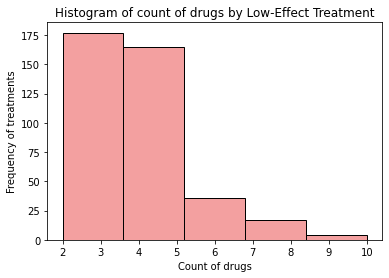

In [13]:
#col = list(colors.cnames.values())
#col = [col[9], col[3]]
col = [mcolors.CSS4_COLORS['brown'], mcolors.CSS4_COLORS['lightcoral']]
ax = sns.histplot(data=low_effect, x='n_drugs', bins=5, legend=False, color=col[1])
ax.set_xlabel('Count of drugs')
ax.set_ylabel('Frequency of treatments')
plt.title('Histogram of count of drugs by Low-Effect Treatment')
plt.savefig('Embeddings/Plots/histogram_negative_treatment.pdf', format='pdf', bbox_inches='tight')
#plt.savefig("histogram_positive_treatment.png", format='png', bbox_inches='tight', dpi=300)

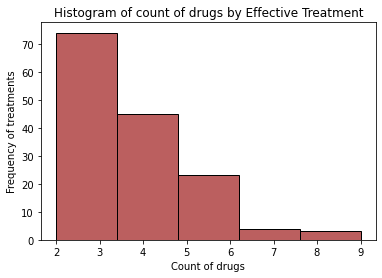

In [14]:
#col = list(colors.cnames.values())
#col = [col[9], col[3]]
col = [mcolors.CSS4_COLORS['brown'], mcolors.CSS4_COLORS['lightcoral']]
ax = sns.histplot(data=effective, x='n_drugs', bins=5, legend=False, color=col[0])
ax.set_xlabel('Count of drugs')
ax.set_ylabel('Frequency of treatments')
plt.title('Histogram of count of drugs by Effective Treatment')
plt.savefig('Embeddings/Plots/histogram_positive_treatment.pdf', format='pdf', bbox_inches='tight')

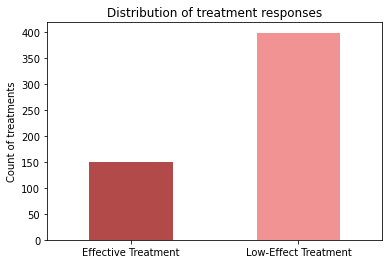

In [15]:
df = pd.DataFrame(data=[[149],[399]], columns=['treatment'], index=['Effective Treatment', 'Low-Effect Treatment'])

ax = df['treatment'].plot(kind="bar", color=col, alpha=0.85,)
plt.xticks(rotation=0, horizontalalignment="center")
plt.ylabel('Count of treatments')
plt.title('Distribution of treatment responses')
plt.savefig('Embeddings/Plots/distribution_treatment.pdf', format='pdf', bbox_inches='tight')

In [13]:
drugBank_id = treatmentKG.get_drugbank_id(set_drugs_low, drugBank_id_name)
treatmentKG.generate_kg_treatment(low_effect, drugBank_id, ddi, 0, 'negative')
drugBank_id = treatmentKG.get_drugbank_id(set_drugs_eff, drugBank_id_name)
treatmentKG.generate_kg_treatment(effective, drugBank_id, ddi, 399, 'positive')


In [14]:
from collections import OrderedDict

In [17]:
def save_ttl_file(graph_ttl):
    #open text file
    ttl_file = open("G2_0.ttl", "w")
    #write string to file
    n = ttl_file.write(graph_ttl)
    #close file
    ttl_file.close()

In [18]:
graph_ttl = open("G2.ttl").read()
graph_ttl = "\n".join(list(OrderedDict.fromkeys(graph_ttl.split("\n"))))
save_ttl_file(graph_ttl)

In [19]:
149/548

0.2718978102189781

In [20]:
((26/110)+(36/110)+(26/110)+(30/109)+(31/109))/5

0.27192660550458714

In [12]:
drugBank_id = treatmentKG.get_drugbank_id(set_drugs, drugBank_id_name)
treatmentKG.generate_kg_treatment(df, drugBank_id, ddi, 6, 'positive')

In [15]:
df = df_treatment.iloc[20:30]
df = df.reset_index()
df = df.drop(columns=['index'])
df

,drug_name,n_drugs
0,"[Atenolol, Carboplatin, Etoposide, Omeprazole]",4.0
1,"[Atorvastatin, Gefitinib, Omeprazole]",3.0
2,"[Atenolol, Carboplatin, Paclitaxel]",3.0
3,"[Ibuprofen, Omeprazole, Paclitaxel]",3.0
4,"[Carboplatin, Enalapril, Paclitaxel]",3.0
5,"[Carboplatin, Simvastatin, Vinorelbine]",3.0
6,"[Cisplatin, Omeprazole, Pemetrexed]",3.0
7,"[Atorvastatin, Carboplatin, Vinorelbine]",3.0
8,"[Cisplatin, Omeprazole, Vinorelbine]",3.0
9,"[Atenolol, Atorvastatin, Docetaxel]",3.0


In [ ]:
Atenolol, Carboplatin, Paclitaxel
Paclitaxel may decrease the excretion rate of Atenolol which could result in a higher serum level.
The risk or severity of adverse effects can be increased when Carboplatin is combined with Paclitaxel.

Carboplatin, Simvastatin, Vinorelbine
	The risk or severity of adverse effects can be increased when Vinorelbine is combined with Carboplatin.
    The metabolism of Simvastatin can be decreased when combined with Vinorelbine.

In [11]:
set_drugs = set(positive_treatment['ct_drug'].unique())
set_drugs.update(set(positive_treatment['ct_drug.1'].unique()))
set_drugs.update(set(positive_treatment['ct_drug.2'].unique()))
set_drugs

{'Afatinib',
 'Carboplatino',
 'Ciclofosfamida',
 'Cisplatino',
 'Docetaxel',
 'Doxorrubicina',
 'Durvalumab (MEDI4736)',
 'Durvalumab(MEDI4736) vs Placebo',
 'Erlotinib',
 'Etopósido VP16',
 'Gefitinib',
 'Gemcitabina',
 'Ipilimumab',
 'Nivolumab',
 'Osimertinib',
 'Otro',
 'Paclitaxel',
 'Pembrolizumab vs placebo',
 'Pemetrexed',
 'Vadimezan (ASA404)',
 'Vincristina',
 'Vinorelbina',
 nan}

In [12]:
drugBank_id_name = pd.read_csv('../store_data/drug/drugBank_id_name.csv', delimiter=",")
display(drugBank_id_name.shape, drugBank_id_name.head())

(14315, 2)

,DrugBankID,DrugName
0,DB00001,Lepirudin
1,DB00002,Cetuximab
2,DB00003,Dornase_alfa
3,DB00004,Denileukin_diftitox
4,DB00005,Etanercept


In [9]:
drug_treatment = pd.DataFrame(set_drugs, columns=['DrugName'])
drugBank_id = pd.merge(drugBank_id_name, drug_treatment,on='DrugName')
#drug_id.to_csv('treatments/MIMIC_drugBank_id.csv', index=False)
drugBank_id

,DrugBankID,DrugName
0,DB00028,Human_immunoglobulin_g
1,DB00186,Lorazepam
2,DB00207,Azithromycin
3,DB00316,Acetaminophen
4,DB00317,Gefitinib
5,DB00335,Atenolol
6,DB00338,Omeprazole
7,DB00361,Vinorelbine
8,DB00381,Amlodipine
9,DB00421,Spironolactone


In [10]:
fix_name = drug_treatment.merge(drugBank_id, how = 'outer' , on='DrugName', indicator=True).loc[lambda x : x['_merge']=='left_only']
fix_name

,DrugName,DrugBankID,_merge


In [16]:
fix_name.DrugName.values

array([nan, 'Carboplatino', 'Vinorelbina', 'Otro', 'Vadimezan (ASA404)',
       'Gemcitabina', 'Vincristina', 'Durvalumab(MEDI4736) vs Placebo',
       'Cisplatino', 'Doxorrubicina', 'Etopósido VP16', 'Ciclofosfamida',
       'Durvalumab (MEDI4736)', 'Pembrolizumab vs placebo'], dtype=object)

In [50]:
list_d = df_treatment.drug_name[15]
list_d

['Atenolol', 'Atorvastatin', 'Carboplatin', 'Vinorelbine']

In [51]:
input_data = drugBank_id.loc[drugBank_id.DrugName.isin(list_d)].DrugBankID.values
union, comorbidity_drug, set_DDIs = deductive_system.load_ddi(ddi, input_data)
union

,EffectorDrugLabel,AffectedDrugLabel,Effect,Impact,precipitantDrug,objectDrug,Effect_Impact
0,Atenolol,Atorvastatin,excretion,decrease,DB00335,DB01076,excretion_decrease
1,Atenolol,Atorvastatin,serum_concentration,increase,DB00335,DB01076,serum_concentration_increase
2,Vinorelbine,Atenolol,metabolism,decrease,DB00361,DB00335,metabolism_decrease


In [52]:
g1, g2, g1_classified, g2_classified = deductive_system.capture_knowledge(union, comorbidity_drug, set_DDIs)
g2_classified

,EffectorDrugLabel,AffectedDrugLabel,Effect_Impact,Class,precipitantDrug,objectDrug
0,Atenolol,Atorvastatin,excretion_decrease,HigherToxicity,DB00335,DB01076
1,Atenolol,Atorvastatin,serum_concentration_increase,HigherToxicity,DB00335,DB01076
2,Vinorelbine,Atenolol,metabolism_decrease,HigherToxicity,DB00361,DB00335
0,Vinorelbine,Atorvastatin,excretion_decrease,HigherToxicity,DB00361,DB01076
0,Vinorelbine,Atorvastatin,serum_concentration_increase,HigherToxicity,DB00361,DB01076
